In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib
%matplotlib
from imutils import paths
import shutil
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

Using matplotlib backend: agg


In [3]:
ORIG_INPUT_DATASET = "/content/drive/MyDrive/final data 7800"
BASE_PATH = "/content/drive/MyDrive/Mini project/dataset"

#define the names of training, validation and testing for directions
TRAIN = "train"
TEST = "test"
VAL = "validation"

CLASSES = ["Violence", "Non_violence"]

BATCH_SIZE = 30

# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
LE_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "le.cpickle"])
BASE_CSV_PATH = "/content/drive/MyDrive/Mini project/output"

# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "V_pg3.model"])

# define the path to the output training history plots
UNFROZEN_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join(["/content/drive/MyDrive/Mini project/output", "warmup.png"])

In [4]:
def plot_training(H, N, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
# loop over the data splits
for split in (TRAIN, TEST, VAL):
  # grab all image paths in the current split
  print("[INFO] processing '{} split'...".format(split))
  p = os.path.sep.join([ORIG_INPUT_DATASET, split])
  imagePaths = list(paths.list_images(p))
  Eyu = {'V':0, 'NV':1}
  # loop over the image paths
  for imagePath in imagePaths:
    # extract class label from the filename
    filename = imagePath.split(os.path.sep)[-1]
    label = CLASSES[int(Eyu[filename.split("_")[0]])]
    print(label)
    # construct the path to the output directory
    dirPath = os.path.sep.join([BASE_PATH, split, label])
    # if the output directory does not exist, create it
    if not os.path.exists(dirPath):
      os.makedirs(dirPath)
    # construct the path to the output image file and copy it
    p = os.path.sep.join([dirPath, filename])
    shutil.copy2(imagePath, p)

[INFO] processing 'train split'...
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence
Violence


KeyboardInterrupt: ignored

In [ ]:
print(len(CLASSES))
#print(label)

2


In [5]:
# derive the paths to the training, validation, and testing
# directories
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])
# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))
print(totalTrain, totalVal, totalTest)

6000 900 900


In [6]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [7]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	valPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	testPath,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE)

Found 6000 images belonging to 2 classes.
Found 900 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


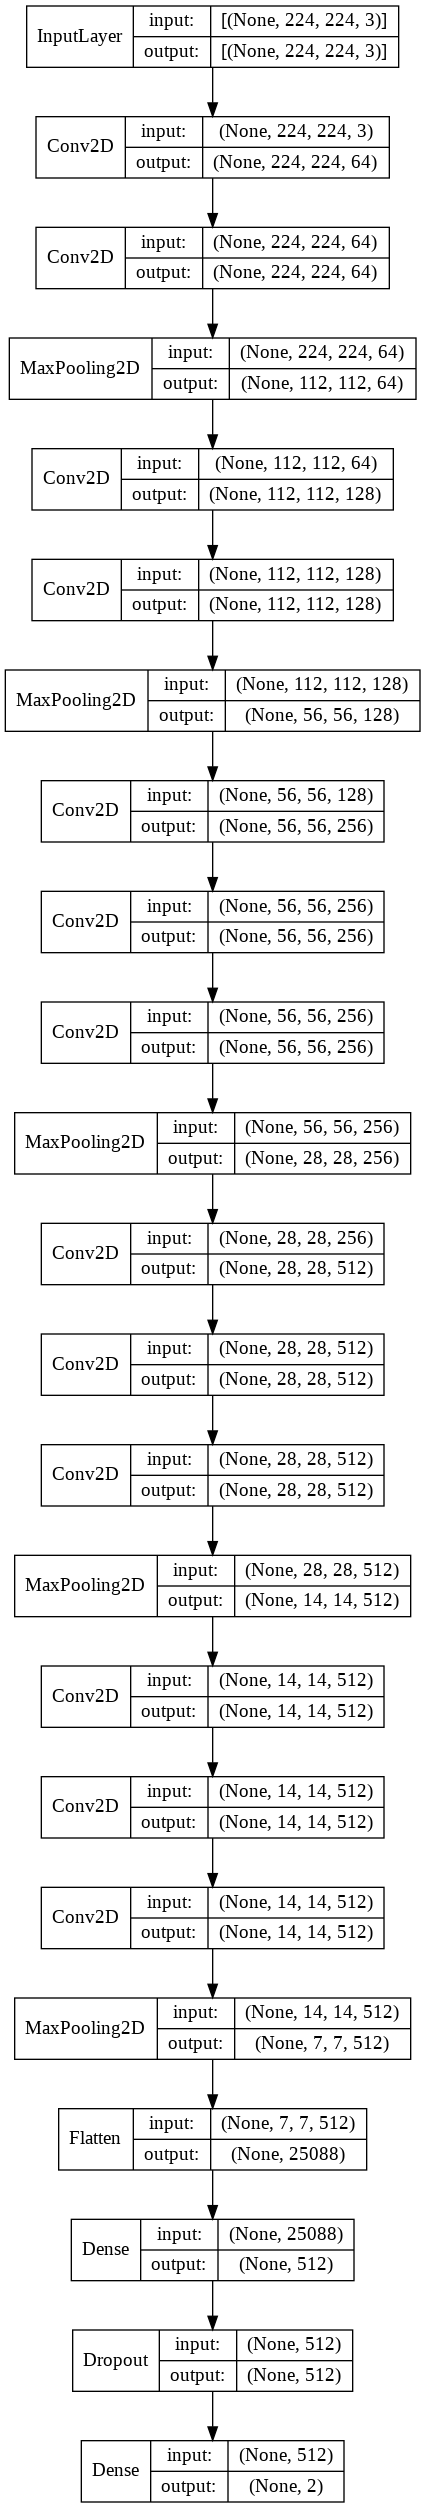

In [10]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

from tensorflow.keras import utils
utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [11]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [12]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [13]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valGen,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=10)

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
200/200 [==============================] - 2696s 13s/step - loss: 1.0530 - accuracy: 0.9015 - val_loss: 0.4456 - val_accuracy: 0.9367
Epoch 2/10
200/200 [==============================] - 103s 515ms/step - loss: 0.3199 - accuracy: 0.9537 - val_loss: 0.2476 - val_accuracy: 0.9556
Epoch 3/10
200/200 [==============================] - 104s 518ms/step - loss: 0.2399 - accuracy: 0.9613 - val_loss: 0.2622 - val_accuracy: 0.9567
Epoch 4/10
200/200 [==============================] - 104s 519ms/step - loss: 0.1724 - accuracy: 0.9655 - val_loss: 0.1466 - val_accuracy: 0.9656
Epoch 5/10
200/200 [==============================] - 103s 516ms/step - loss: 0.1277 - accuracy: 0.9737 - val_loss: 0.1167 - val_accuracy: 0.9722
Epoch 6/10
200/200 [==============================] - 103s 517ms/step - loss: 0.1314 - accuracy: 0.9705 - val_loss: 0.1427 - val_accuracy: 0.9611
Epoch 7/10
200/200 [==============================] - 104s 520ms/step - loss: 0.0968 - accuracy: 0.9775 - val_loss: 0.1244 - 

In [15]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(x=testGen,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
plot_training(H, 10, WARMUP_PLOT_PATH)

[INFO] evaluating after fine-tuning network head...
              precision    recall  f1-score   support

Non_violence       0.98      0.99      0.98       450
    Violence       0.99      0.98      0.98       450

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900



In [16]:
# reset our data generators
trainGen.reset()
valGen.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ff0a0481b50>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a043f850>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a047f550>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff0a0500f10>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a03c78d0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a03cb710>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff0a03d7310>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a03d2f50>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a03da090>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ff0a03e5250>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ff0a03e9a10>: False
<tensorflow.python.keras.layers.convolutional.Conv2D

In [17]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit(
	x=trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=valGen,
	validation_steps=totalVal // BATCH_SIZE,
	epochs=5)

[INFO] re-compiling model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
200/200 [==============================] - 106s 520ms/step - loss: 0.0702 - accuracy: 0.9810 - val_loss: 0.0676 - val_accuracy: 0.9811
Epoch 2/5
200/200 [==============================] - 105s 523ms/step - loss: 0.0509 - accuracy: 0.9877 - val_loss: 0.0555 - val_accuracy: 0.9889
Epoch 3/5
200/200 [==============================] - 105s 523ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.0501 - val_accuracy: 0.9867
Epoch 4/5
200/200 [==============================] - 104s 521ms/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 0.0415 - val_accuracy: 0.9911
Epoch 5/5
200/200 [==============================] - 105s 523ms/step - loss: 0.0263 - accuracy: 0.9933 - val_loss: 0.0575 - val_accuracy: 0.9856


In [19]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict(x=testGen,
	steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
plot_training(H, 5, UNFROZEN_PLOT_PATH)
# serialize the model to disk
print("[INFO] serializing network...")
model.save(MODEL_PATH, save_format="h5")

[INFO] evaluating after fine-tuning network...
              precision    recall  f1-score   support

Non_violence       0.98      1.00      0.99       450
    Violence       1.00      0.98      0.99       450

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900

[INFO] serializing network...


In [20]:
model.save("/content/drive/MyDrive/Mini project/output/vmodel.h5")